This is the fourth of a series about bitcoin futures. We will use a Monte Carlo simulation to model the profitability of an arbitrage strategy.

- [Part 1 - Getting the data]({% post_url 2019-05-11-bitcoin-futures-arbitrage-part-1 %})
- [Part 2 - Were there arbitrage profits in the past?]({% post_url 2019-05-12-bitcoin-futures-arbitrage-part-2 %})
- [Part 3 - Perpetual futures 101]({% post_url 2019-05-20-bitcoin-futures-arbitrage-part-3 %})
- [Part 4 - Arbitrage Profit Analysis]({% post_url 2019-05-24-bitcoin-futures-arbitrage-part-4 %})


Let's load our perpetual data again.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from matplotlib import style
import seaborn as sns
from IPython.core.pylabtools import figsize
import warnings
import glob
import statsmodels.api as sm
import datetime


%matplotlib inline
plt.style.use('ggplot')

np.random.seed(17098234)

In [110]:
df = pd.read_csv('/home/chris/code/deribit-future-arb/downloads/BTC-PERPETUAL.txt')

In [111]:
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.index = df['date']
df = df.drop(columns=['timestamp', 'date', 'instrument_name'])
df.columns = ['perpetual', 'index']

In [112]:
df['ratio'] = df['perpetual'] / df['index']

In [113]:
df['funding'] = np.maximum(0.0005, df['ratio'] - 1) +  np.minimum(-0.0005, df['ratio'] - 1)

In [114]:
# df_D = df.resample('D').last()
# df_H = df.resample('H').last().interpolate()
df_5 = df.resample('5Min').last().interpolate()

# Monte Carlo Simulation

Let's calculate the profitability of arbitrage, given those prices from earlier that I sampled from a random moment in time.

In [115]:
# Starting prices
start_future_price = 7270.13
start_perpetual_price = 7325.88
start_index_price = 7335.49

days = 46

# Initial Prices are the set of index, perpetual, and futures prices I recorded and used in the example earlier.
# This will simulate the profit considering you bought and sold for those prices.
# Enter in new prices to get a profitability analysis for those prices

I make a few assumptions:

1. The trades are done with 1 BTC of exposure.
2. The volatility of BTC is about 5% daily, based on a quick look [here](https://www.sk3w.co/options).
3. The BTC index price at the future's expiration date will be calculated by running forward random returns until expiration.
4. The perpetual price at the future's expiration date will equal the index price, times by a perpetual index ratio sampled from our perpetual index distribution.
5. The average funding rate over the investment period will be sampled from the distribution of past average funding rates over the same length period.

Here's the full model specification as:

$$\text{btc_daily_returns} \sim N(0, 0.05)$$
$$\text{end_index_price} \sim f(\text{start_index_price}, \text{btc_daily_returns})$$
$$\text{perpetual_index_ratio} \sim \text{real perpetual index data}$$
$$\text{end_perpetual_price} = \text{end_index_price} * \text{perpetual_index_ratio}$$
$$\text{average_funding_rate} \sim \text{real funding rate data}$$
$$\text{total_funding} = f(\text{average_funding_rate}, \text{days})$$
$$\text{profit} = f(\text{end_index_price}, \text{end_perpetual_price}, \text{total_funding})$$


In [116]:
trials = 1000000

# Amount of btc trade
btc = 1

daily_btc_returns = np.random.normal(loc=0.00, scale=0.05, size=(trials, days))

total_btc_return = np.prod(1 + daily_btc_returns, axis=1)

end_index_price = total_btc_return * start_index_price

end_perpetual_ratio = np.random.choice(df_5['ratio'], size=trials)

end_perpetual_price = end_index_price * end_perpetual_ratio

# On deribit futures are restricted to contracts of $10
# That means your expoure might not be perfectly equal in long and short
future_amount = round(start_future_price * btc, -1)
perpetual_amount = round(start_perpetual_price * btc, -1)

# Payoffs from long future, short perpetual
long_future_payoff = future_amount * (1/start_future_price - 1/end_index_price) * end_index_price
short_perpetual_payoff = -perpetual_amount * (1/start_perpetual_price - 1/end_perpetual_price) * end_index_price

short_perpetual_profit = long_future_payoff + short_perpetual_payoff

# Payoffs from short future, long perpetual
short_future_payoff = -future_amount * (1/start_future_price - 1/end_index_price) * end_index_price
long_perpetual_payoff = perpetual_amount * (1/start_perpetual_price - 1/end_perpetual_price) * end_index_price

long_perpetual_profit = short_future_payoff + long_perpetual_payoff

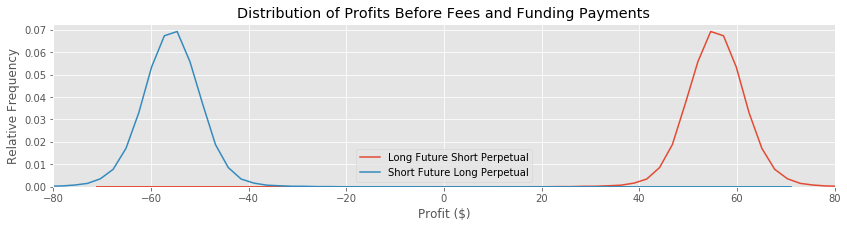

In [117]:
figsize(14, 3)
sns.kdeplot(short_perpetual_profit, label='Long Future Short Perpetual')
sns.kdeplot(long_perpetual_profit, label='Short Future Long Perpetual')
plt.xlabel('Profit ($)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Profits Before Fees and Funding Payments')
plt.xlim([-80, 80])
plt.show()

## Fees

Our model has not included any fees. So we will do those calculations and update our profits.

The fees for trading on Deribit can be found [here](https://www.deribit.com/pages/information/fees)

They are listed below in a percentage of the underlying asset (negative numbers mean a rebate):

Instrument | Maker Trade Fee | Taker Trade Fee | Delivery Fee
--- | --- | --- | ---
Future | 0.05% | -0.02% | 0.025%
Perpetual | 0.075% | -0.025% | 0.075%

It is possible to earn a profit on trades by only setting limit orders. Then our total fees would be:

Trade | Fees
--- | ---
Buy Future | -0.02%
Sell Perpetual | -0.025%
Settle Future | 0.025%
Buy Perpetual | -0.025%

For a total rebate of 0.045% of the underlying asset.

If we used all market orders the fees would be:

Trade | Fees
--- | ---
Buy Future | 0.05%
Sell Perpetual | 0.075%
Settle Future | 0.025%
Buy Perpetual | 0.075%

For a total fee amount of 0.225%.

In [118]:
taker_fees = start_index_price * 0.225 / 100

maker_rebate = start_index_price * 0.045 / 100

short_perpetual_taker = short_perpetual_profit - taker_fees
short_perpetual_maker = short_perpetual_profit + maker_rebate

long_perpetual_taker = long_perpetual_profit - taker_fees
long_perpetual_maker = long_perpetual_profit + maker_rebate

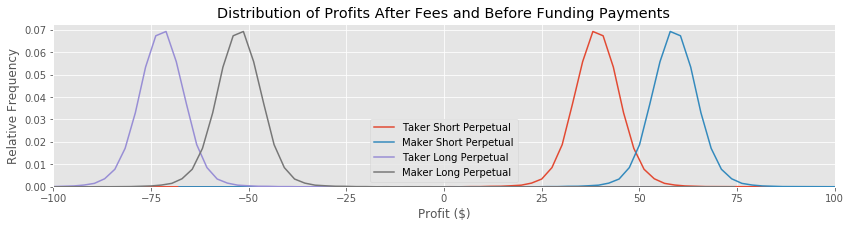

In [119]:
figsize(14,3)
sns.kdeplot(short_perpetual_taker, label='Taker Short Perpetual')
sns.kdeplot(short_perpetual_maker, label='Maker Short Perpetual')
sns.kdeplot(long_perpetual_taker, label='Taker Long Perpetual')
sns.kdeplot(long_perpetual_maker, label='Maker Long Perpetual')
plt.xlabel('Profit ($)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Profits After Fees and Before Funding Payments')
plt.xlim([-100, 100])
plt.show()

Going short on the perpetual is the most profitable strategy, as expected. So far we have a fairly narrow distribution around \\$60 profit, exactly what we expected from the difference in starting prices. We will limit our analysis to going short on the perpetual and paying maker fees.

## Funding

We need to know what the expected funding rate is over the time period. So we will take average funding rates from a number of time periods the same length as our time horizon.

In [120]:
five_min_per_day = int(24 * 60 / 5)
samples = five_min_per_day * days
windows = np.convolve(df_5['funding'], np.ones((samples,))/samples, mode='valid')
funding_rate = np.random.choice(windows, size=trials)

In [121]:
funding_rate = np.random.normal(loc=windows.mean(), scale=windows.std(), size=trials)

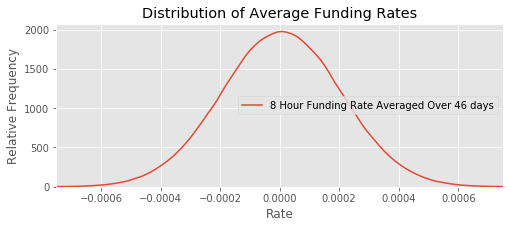

In [122]:
figsize(8,3)
sns.kdeplot(funding_rate, label=f'8 Hour Funding Rate Averaged Over {days} days')
plt.xlabel('Rate')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Average Funding Rates')
plt.xlim([-0.00075, 0.00075])
plt.show()

In [123]:
funding_payments = perpetual_amount * funding_rate * 3 * days
print(funding_payments.mean())
print(funding_payments.std())

5.816138087153054
203.72558454370662


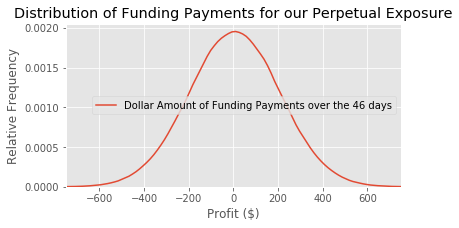

In [124]:
figsize(6,3)
sns.kdeplot(funding_payments, label=f'Dollar Amount of Funding Payments over the {days} days')
plt.xlabel('Profit ($)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Funding Payments for our Perpetual Exposure')
plt.xlim([-750, 750])
plt.show()

In [125]:
final_short_perpetual_taker = short_perpetual_taker + funding_payments
final_short_perpetual_maker = short_perpetual_maker + funding_payments

final_long_perpetual_taker = long_perpetual_taker - funding_payments
final_long_perpetual_maker = long_perpetual_maker - funding_payments

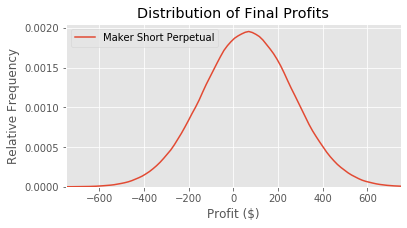

In [126]:
figsize(6,3)
# sns.kdeplot(final_short_perpetual_taker, label='Taker Short Perpetual')
sns.kdeplot(final_short_perpetual_maker, label='Maker Short Perpetual')
# sns.kdeplot(final_long_perpetual_taker, label='Taker Long Perpetual')
# sns.kdeplot(final_long_perpetual_maker, label='Maker Long Perpetual')
plt.xlabel('Profit ($)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Final Profits')
plt.xlim([-750, 750])
plt.show()

In [127]:
print(final_short_perpetual_maker.mean())
print(final_short_perpetual_maker.std())

# print(final_long_perpetual_maker.mean())
# print(final_long_perpetual_maker.std())

64.90532597657923
203.83377397350054


## Rate of Return

The model suggests that our strategy has positive expected profit (of approximately \\$60) with extremely high variance. And the benefit of this strategy, compared to traditional arbitrage, is that we earn that \\$60 using a much lower initial investment. 

Deribit futures allow up to 100x leverage. And Deribit has a portfolio margin system where your required margin is a function of your total portfolio risk due to bitcoin price fluctuations. The details are [here](https://www.deribit.com/pages/docs/portfoliomargin). As we are neutral on bitcoin, our required margin is only 1.2%. But we would still need margin to cover fluctuations in the funding rate.

Below I will calculate the single largest day of funding.

In [128]:
single_day = np.max(np.abs(df_5.resample('D').mean()['funding']))
single_day

0.0020585245465266733

This gives a good estimation of our required margin. It would be a good idea to have the minimum 1.2% plus enough to cover 5 days of the worst luck.

In [129]:
margin_amount = (single_day * 3 * perpetual_amount * 5) + (perpetual_amount * 0.012)
margin_amount

314.29477389060776

This amount of upfront investment is much less than doing arbitrage the traditional way. That requires the purchase of 1 BTC or about \\$7000 of initial cash outflow.

## Margin Risk

Depositing margin at Deribit means holding the margin in bitcoins while you wait for the future to expire. This exposes you to bitcoin risk as your margin will be worth more or less as the price changes. We can see that in the following graph.

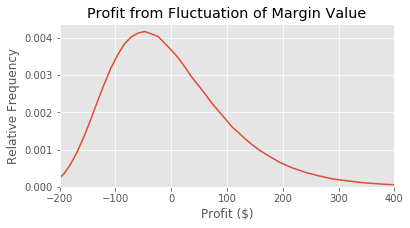

In [130]:
final_margin = margin_amount * (end_index_price/start_index_price)

margin_profit = final_margin - margin_amount

sns.kdeplot(margin_profit)
plt.title('Profit from Fluctuation of Margin Value')
plt.ylabel('Relative Frequency')
plt.xlabel('Profit ($)')
plt.xlim(-200,400)
plt.show()

Even holding a small amount of bitcoin is risky. A better solution is to short the perpetual for the amount we have in margin.

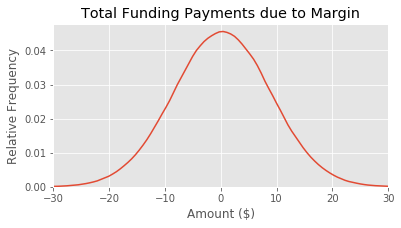

In [131]:
margin_funding_payments = margin_amount * funding_rate * 3 * days

sns.kdeplot(margin_funding_payments)
plt.ylabel('Relative Frequency')
plt.xlabel('Amount ($)')
plt.title('Total Funding Payments due to Margin')
plt.xlim(-30,30)
plt.show()

## Calculating Rate of Return

We have calculated the total expected profit on making the arbitrage trade and holding the assets until expiration. To compare with other investments, let's calculate the annualized rate of return. The return will be our total profits over our initial required margin. 

In [132]:
profit = final_short_perpetual_maker + margin_funding_payments
# profit = final_long_perpetual_maker + margin_funding_payments

# Rate of Return (simple annualized) on the long perpetual strategy

RR = (profit / margin_amount) * (365 / days) * 100

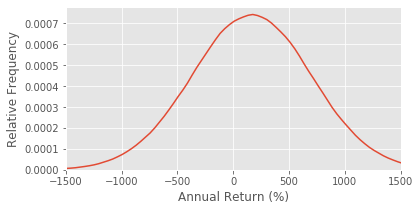

In [133]:
figsize(6,3)
sns.kdeplot(RR)
plt.ylabel('Relative Frequency')
plt.xlabel('Annual Return (%)')
plt.xlim(-1500,1500)
plt.show()

In [134]:
print(RR.mean())
print(RR.std())

164.4915854124958
536.6479492759993


Our strategy has an extremely high rate of return with an insanely high variance. A 150% expected return with a 500% standard deviation is crazy high. But it makes sense with expecting to earn \\$60 on \\$300 of upfront capital in under 50 days.

A globally diversified stock portfolio has something like a real expected rate of return of 6% with a standard deviation of 15%.

## Sensitivity Analysis

Let's check which input variables have the biggest effect on profits.

First we will see how the expected return varies as a function of our model parameters. We can do this by only looking at the modelled situations that happened to have a parameter fall within a specific range.

In [135]:
def linear_transform(x, xs):
    max_xs = np.max(xs)
    min_xs = np.min(xs)
    return (x - min_xs) / (max_xs - min_xs)

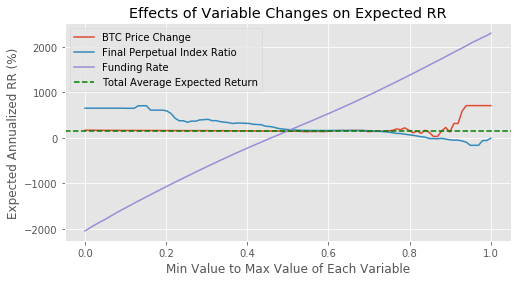

In [136]:
figsize(8,4)

btc_price_change = end_index_price / start_index_price - 1
labels = ['BTC Price Change', 'Final Perpetual Index Ratio', 'Funding Rate']
input_variables = [btc_price_change, end_perpetual_ratio, funding_rate]

# Sensitivity analysis
# expected value as each variable changes

for index, input_variable in enumerate(input_variables):
    # split variable into groups
    step = (input_variable.max() - input_variable.min())/10
    ys = []
    xs = np.linspace(input_variable.min(), input_variable.max(), 100)
    for i in xs:
        ## values where input_variable is close to i
        bool_array = np.logical_and(input_variable < i + step, input_variable > i - step)
        ys.append(RR[bool_array].mean())
    
    # transform xs to be on scale of 0 to 1 for the graph
    linear_xs = []
    for x in xs:
        linear_xs.append(linear_transform(x, xs))
    plt.plot(linear_xs, ys, label=labels[index])

plt.xlabel('Min Value to Max Value of Each Variable')
plt.ylabel('Expected Annualized RR (%)')
plt.title('Effects of Variable Changes on Expected RR')
plt.axhline(y=RR.mean(), color='g', linestyle='--', label='Total Average Expected Return')
plt.legend()
plt.show()

Most of these variables are normally distributed and thus there are fewer samples near the max and min values. This explains the variance of the RR in the bottom and top percentiles of parameter values.

## Profit Factors

The single biggest factor in the profitability of this strategy is the funding rate we expect over the investment period.

Otherwise we are approximately bitcoin neutral and slightly dependant on the final perpetual index ratio.

The return seems to be only really strongly correlated with the average funding rate. But the funding rate appeared to be a random process. It's likely the funding rate isn't highly correlated with conventional asset classes such as stocks or bonds and thus this strategy is not correlated with the market.

This strategy has poor risk-return characteristics if you were considering it as your only investment. But its low correlation with other assets makes it likely to be a part of an optimal mean-variance portfolio. In the next post I will perform a Markowitz portfolio optimization and see how this strategy fits as part of a portfolio.

## Was this situation unusual?

Did I get lucky and find a particularly profitable moment in time that was quickly arbitraged away?

Below I graph the ratio used in this analysis compared to the historical data.

In [137]:
# Get a list of files with the historical data
files = glob.glob('/home/chris/code/deribit-future-arb/downloads/futures/*.txt')

# Combine the files into one large pandas df
data_list = []
for file in files:
    data = pd.read_csv(file)
    data_list.append(data)
df_futures = pd.concat(data_list)

df_futures['ratio'] = df_futures['price'] / df_futures['index_price']

instrument_names = ['BTC-27JUL18', 'BTC-31AUG18', 'BTC-28SEP18', 'BTC-28DEC18', 'BTC-29MAR19']

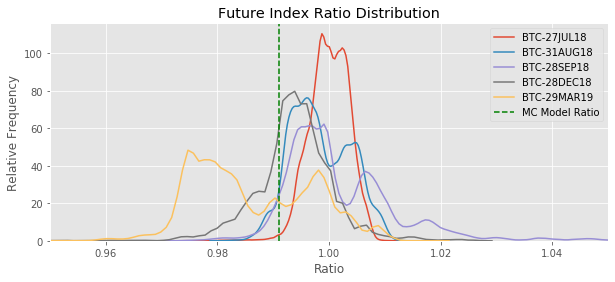

In [138]:
figsize(10,4)
for i, instrument in enumerate(instrument_names):
    temp = df_futures[df_futures['instrument_name'] == instrument]
    sns.kdeplot(temp['ratio'], label=instrument)
plt.xlabel('Ratio')
plt.ylabel('Relative Frequency')
plt.title('Future Index Ratio Distribution')
plt.xlim(0.95, 1.05)
specific_ratio=start_future_price/start_index_price
plt.axvline(x=specific_ratio, color='g', linestyle='--', label='MC Model Ratio')
plt.legend()   
plt.show()

The prices used in this model are not particularly unusual. These situations happen frequently.

## Is the order book deep enough?

In this post I assumed we just got one bitcoin of exposure, using about $300 of initial capital. That's not a large investment. And as you attempt to arbitrage the differences in prices, you will push the prices closer together and reduce your profits.

So I took a quick look at the exchange. Right now as I type this, it would take about $100,000 to move the perpetual price by 0.05%.

Our analysis was done based on a price difference of about 1% between the future and the perpetual. If you change the input prices it still has a large expected return at 0.95% difference.

I predict that this strategy will be part of an optimal mean-variance portfolio and that you could put millions into this and still get a risk-return profile that should be included in an optimal portfolio. I will check this prediction in my next post.

# Conclusion

We created a model for the profitability of an arbitrage strategy given any future and perpetual prices. This model could be turned into a trading strategy. 

1. Run this simulation on a variety of future/perpetual price ratios for different times to expiry. Cache the expected return and variance of each.
2. Calculate covariances between these strategies and other assets.
3. Get live data on ratios.
4. Calculate optimal portfolio using expected returns and covariances.
5. Invest